Helpers.py loaded successfully.
115
Processing 35 files (350 seconds)
Raw data shape: (218750, 1376)
Time points: 218750
Distance points: 1376
Total duration: 350.0 seconds


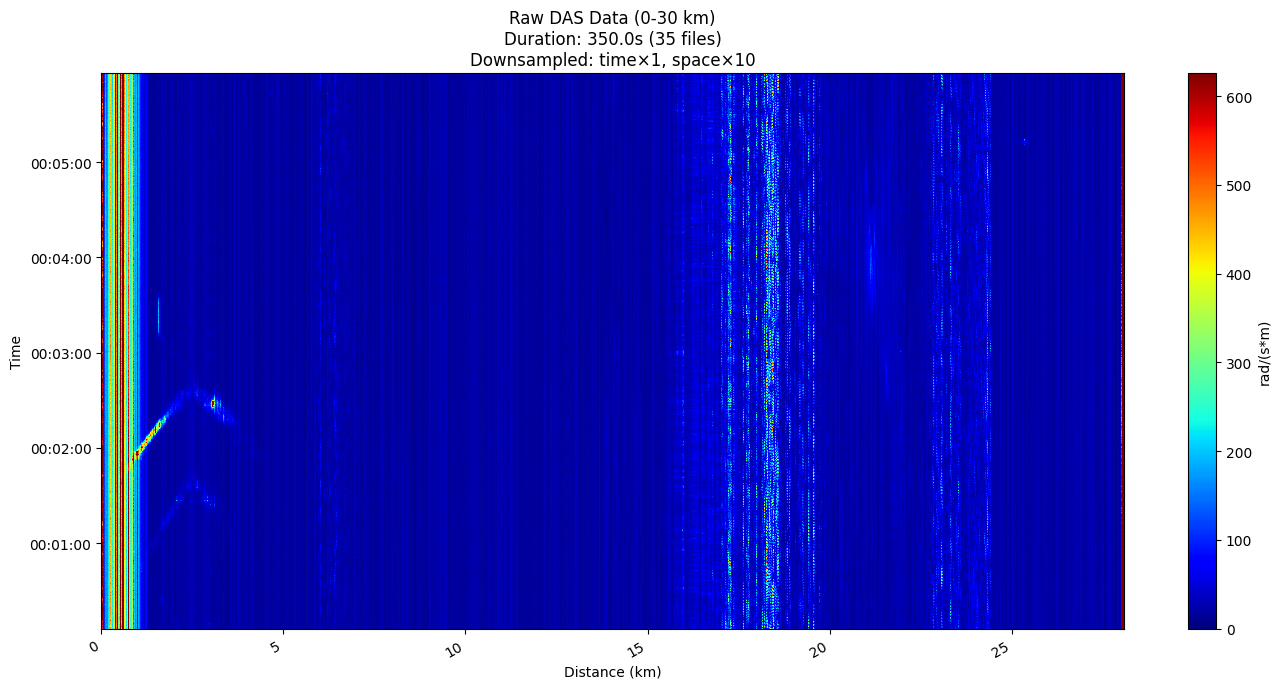

In [1]:
# Import required libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta,timezone
import glob
import os
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal import butter, filtfilt, firwin
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey
from scipy.interpolate import interp1d
# from matplotlib.colors import LinearSegmentedColomap
from matplotlib.ticker import AutoMinorLocator
from Helpers import *

# Set up matplotlib for inline plotting
%matplotlib inline


# Define the directory containing your HDF5 files
directory= "data/GC_data"  # Change this to your directory path


# Get all HDF5 files in the directory
file_paths = sorted(glob.glob(os.path.join(directory, '*.hdf5')))
print(len(file_paths))
if not file_paths:
    print(f"No HDF5 files found in {directory}")
else:
# Parameters for data processing
    dmin_km = 0      # Minimum distance in km
    dmax_km = 30   # Maximum distance in km
    chunk_size = 35   # CONTROL THIS: Number of files to process (each file = 10 seconds)
    sample_step = 1 # Temporal downsampling factor jo færrere den her værdi desto langsommere, jo højere desto hurtigre og mere urpæcist.
    channel_step = 10 # Spatial downsampling factor hvor meget detalje der er med, vi beholder flere kanaler langs kabelet. der er måske 30000.

    # Process first file to get parameters
    start_time, dt, dx, channels, _ = extract_metadata(file_paths[0])
    fs = 1/dt
    # Create distance axis
    distance_array_m = (channels) * dx
    distance_array_km = distance_array_m / 1000
    dist_mask = (distance_array_km >= dmin_km) & (distance_array_km <= dmax_km)
    distances = distance_array_km[dist_mask][::channel_step]

    # Initialize data storage
    all_data = []
    time_axis = []

    # Process multiple files based on chunk_size
    for file_idx in range(min(chunk_size, len(file_paths))):
        file_path = file_paths[file_idx]

        file_start_time, file_dt, _, _, file_num_samples = extract_metadata(file_path)
        
        with h5py.File(file_path, 'r') as f:
            data = f['data'][::sample_step, dist_mask][:, ::channel_step]

            # Create proper time axis for this file
            num_samples = data.shape[0]
            file_duration = num_samples * file_dt * sample_step

            # Calculate absolute times for this file
            # file_start_datetime = datetime.utcfromtimestamp(file_start_time)
            file_start_datetime = datetime.fromtimestamp(file_start_time, tz=timezone.utc)

            time_deltas = np.arange(0, num_samples) * (file_dt * sample_step)
            file_times = [file_start_datetime + timedelta(seconds=float(t)) for t in time_deltas]

            all_data.append(data)
            time_axis.extend(file_times)

    # Combine data from all files
    if len(all_data) > 1:
        combined_data = np.vstack(all_data)
    else:
        combined_data = all_data[0]

    print(f"Processing {chunk_size} files ({chunk_size * 10} seconds)")
    print(f"Raw data shape: {combined_data.shape}")
    #print(f"Filtered data shape: {filtered_data.shape}")
    print(f"Time points: {len(time_axis)}")
    print(f"Distance points: {len(distances)}")
    print(f"Total duration: {(time_axis[-1] - time_axis[0]).total_seconds():.1f} seconds")

    #Plot raw data (time-distance plot)
    plt.figure(figsize=(14, 7))  # Wider figure for longer durations
    vmax_amp = np.percentile(np.abs(combined_data), 99)


    # Set extent with distances increasing from bottom to top
    img = plt.imshow(abs(combined_data),
                aspect='auto',
                extent=[distances[0], distances[-1],
                        mdates.date2num(time_axis[0]),
                        mdates.date2num(time_axis[-1])],
                cmap='jet',
                vmin=-0,
                vmax=vmax_amp)

    ax = plt.gca()
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gcf().autofmt_xdate()

    plt.ylabel('Time')
    plt.xlabel('Distance (km)')
    duration_seconds = (time_axis[-1] - time_axis[0]).total_seconds()
    plt.title(f'Raw DAS Data ({dmin_km}-{dmax_km} km)\n'
            f'Duration: {duration_seconds:.1f}s ({chunk_size} files)\n'
            f'Downsampled: time×{sample_step}, space×{channel_step}')
    plt.colorbar(img, label='rad/(s*m)')
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import h5py
from datetime import datetime, timedelta, timezone
from Helpers import *
from sklearn.preprocessing import MinMaxScaler
import random
from tqdm import tqdm
import os 
import glob 

# NOTE: Since you confirmed Helpers.py is loaded, we skip the mock definition of extract_metadata here.
# Please ensure you have: from Helpers import extract_metadata, or define it here if necessary.

# --- FILE PATH ACQUISITION (USER'S LOGIC) ---
directory = "data/GC_data"  # Your directory path
file_paths = sorted(glob.glob(os.path.join(directory, '*.hdf5'))) 

# Used for simulated anomaly labeling logic in the test set.
_mock_file_names = [f'data_file_{i}_{"anomaly" if i > 90 else "normal"}.hdf5' for i in range(len(file_paths))]
print(f"Discovered {len(file_paths)} real HDF5 files in {directory}.")
# --- END FILE PATH ACQUISITION ---


# --- CONFIGURATION ---
dmin_km = 0
dmax_km = 30
chunk_size = 35  # Number of files to process (350 seconds)
sample_step = 1 
channel_step = 20 #less information 

# Model Patching Parameters (Input image size for the CAE)
TIME_PATCH_STEPS = 128  # Time dimension of the patch
DISTANCE_PATCH_STEPS = 128 # Distance dimension of the patch
PATCH_OVERLAP = 0.1  # 10% overlap for comprehensive coverage

# Global variables initialized once
global dist_mask 
global distances
dist_mask = None


# --- 1. LOAD AND COMBINE DATA ---
print("--- 1. LOADING AND COMBINING RAW DATA ---")
# Get essential metadata only once (assuming dx is constant)
try:
    # Attempt to use the real extract_metadata function if it's available
    _, _, dx, _, _ = extract_metadata(file_paths[0])
except NameError:
    # Mock fallback for dx if extract_metadata is not defined here
    dx = 1.0 


all_data = []
# Process multiple files based on chunk_size
for file_idx in tqdm(range(min(chunk_size, len(file_paths))), desc="Loading and Masking Files"):
    file_path = file_paths[file_idx]
    
    # Get metadata for the current file
    try:
        _, _, _, channels_total, file_num_samples = extract_metadata(file_path)
    except NameError:
        # Mock fallback for metadata
        channels_total = 30000 
        file_num_samples = 10000

    # --- ACTUAL HDF5 LOADING LOGIC ---
    data_raw = None
    try:
        with h5py.File(file_path, 'r') as f:
            data_raw = f['data'][:]
            
            # --- SIMULATED ANOMALY INJECTION FOR TESTING ONLY ---
            if file_idx > (len(file_paths) * 0.8): 
                 if 'anomaly' in _mock_file_names[file_idx]: 
                    start_t = random.randint(1000, 9000)
                    end_t = start_t + 500
                    start_d = random.randint(500, 2500)
                    end_d = start_d + 100
                    data_raw[start_t:end_t, start_d:end_d] += 5.0 
            # --- END SIMULATED ANOMALY INJECTION ---

    except Exception as e:
        print(f"\nError loading {file_path}. Using mock data instead. Error: {e}")
        # Fallback to a mock data array if HDF5 reading fails or mock metadata is needed
        data_raw = np.random.normal(0, 0.1, size=(file_num_samples, channels_total)) 
    # --- END ACTUAL HDF5 LOADING LOGIC ---
    
    if data_raw is None:
        continue

    # --- FIX FOR INDEXERROR (Dimension Mismatch) ---
    # 1. Check if the distance mask needs to be initialized or updated.
    if dist_mask is None or dist_mask.shape[0] != data_raw.shape[1]:
        
        current_channel_count = data_raw.shape[1]
        
        # 2. Redefine the distance axis based on the *actual* number of channels loaded (e.g., 13752).
        distance_array_m = (np.arange(current_channel_count)) * dx
        distance_array_km = distance_array_m / 1000
        
        # 3. Create the mask based on the distance range (dmin_km to dmax_km).
        dist_mask = (distance_array_km >= dmin_km) & (distance_array_km <= dmax_km)
        
        # 4. Get the downsampled distance values for reference (not used in filtering here, but useful).
        distances = distance_array_km[dist_mask][::channel_step]
    # --- END FIX ---
    

    # Apply temporal downsampling (first index) and spatial filtering (second index with boolean mask)
    # The boolean mask size is now guaranteed to match data_raw.shape[1]
    data = data_raw[::sample_step, dist_mask][:, ::channel_step]
    all_data.append(data)


# Combine data into a single (Time, Distance) matrix
combined_data = np.vstack(all_data) if len(all_data) > 1 else all_data[0]

print(f"Total Combined Data Shape (Time, Dist): {combined_data.shape}")
print("-" * 50)


# --- 2. NORMALIZATION ---
print("--- 2. NORMALIZING DATA (MinMaxScaler) ---")
# Normalize the entire combined dataset globally
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(combined_data.ravel().reshape(-1, 1)).reshape(combined_data.shape)
print(f"Normalized Data Shape: {normalized_data.shape}")
print("-" * 50)


# --- 3. 2D PATCH EXTRACTION AND SIMULATED LABELING ---
# Split the data into Training (assumed Normal) and Test (Normal + Anomaly) sets.
train_ratio = 0.8
split_idx = int(normalized_data.shape[0] * train_ratio)
train_data_raw = normalized_data[:split_idx, :]
test_data_raw = normalized_data[split_idx:, :]

def create_patches_and_labels(data_matrix, time_window, dist_window, overlap_factor, is_test_set=False):
    """Slices the Distance-Time matrix into overlapping 2D patches (images)."""
    patches = []
    labels = []
    
    time_steps, dist_channels = data_matrix.shape
    
    # Calculate step size based on overlap
    time_step_size = max(1, int(time_window * (1 - overlap_factor)))
    dist_step_size = max(1, int(dist_window * (1 - overlap_factor)))

    for t in range(0, time_steps - time_window + 1, time_step_size):
        for d in range(0, dist_channels - dist_window + 1, dist_step_size):
            patch = data_matrix[t:t + time_window, d:d + dist_window]
            
            if patch.shape == (time_window, dist_window):
                patches.append(patch)
                
                # --- SIMULATED LABELING LOGIC (For Test Set only) ---
                if is_test_set:
                    # Simulates ground truth: if any pixel is extremely high (our mock anomaly), label it 1.
                    if np.max(patch) > 0.8: 
                        labels.append(1) # Anomaly
                    else:
                        labels.append(0) # Normal
                else:
                    labels.append(0) # Training set is assumed all normal

    return np.array(patches), np.array(labels)

# Generate Patches and Labels
X_train_raw, _ = create_patches_and_labels(
    train_data_raw, TIME_PATCH_STEPS, DISTANCE_PATCH_STEPS, PATCH_OVERLAP, is_test_set=False
)
X_test_raw, y_test_simulated = create_patches_and_labels(
    test_data_raw, TIME_PATCH_STEPS, DISTANCE_PATCH_STEPS, PATCH_OVERLAP, is_test_set=True
)

# Reshape for CNN input (batch_size, height, width, channels)
X_train = X_train_raw[..., np.newaxis]
X_test = X_test_raw[..., np.newaxis]

print(f"X_train (Normal Data for Training) Shape: {X_train.shape}")
print(f"X_test (Test Data for Evaluation) Shape: {X_test.shape}")
print(f"y_test_simulated (Simulated Labels) Shape: {y_test_simulated.shape}")

# Store the necessary variables for the next notebook cell
%store X_train X_test y_test_simulated

Discovered 115 real HDF5 files in data/GC_data.
--- 1. LOADING AND COMBINING RAW DATA ---


Loading and Masking Files: 100%|██████████| 35/35 [00:38<00:00,  1.10s/it]


Total Combined Data Shape (Time, Dist): (218750, 1376)
--------------------------------------------------
--- 2. NORMALIZING DATA (MinMaxScaler) ---
Normalized Data Shape: (218750, 1376)
--------------------------------------------------
X_train (Normal Data for Training) Shape: (54660, 128, 128, 1)
X_test (Test Data for Evaluation) Shape: (13640, 128, 128, 1)
y_test_simulated (Simulated Labels) Shape: (13640,)


OverflowError: serializing a string larger than 4 GiB requires pickle protocol 4 or higher

In [ ]:
import numpy as np 
import os 
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tqdm import tqdm

# Note: Using os.environ to suppress TensorFlow C++ logging warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

%store -r X_train # Load data from the previous cell

# --- CAE ARCHITECTURE DEFINITION ---
def build_cae(input_shape):
    """
    Builds a Convolutional Autoencoder (CAE) for 2D DAS patches.
    Encoder reduces dimension, Decoder reconstructs the input.
    """
    input_img = Input(shape=input_shape)
    
    # ENCODER (Downsampling)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x) # ~64x64x32
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x) # ~32x32x16
    
    # LATENT SPACE (Bottleneck)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoded')(x) # ~32x32x8

    # DECODER (Upsampling)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x) # ~64x64x16
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) # ~128x128x32
    
    # Output layer - must match the number of channels of the input (1)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 
    
    cae = Model(input_img, decoded)
    return cae

# --- MODEL INITIALIZATION AND COMPILATION ---
input_shape = X_train.shape[1:]
cae_model = build_cae(input_shape)

# Compile using Adam optimizer and Mean Squared Error (MSE) loss
cae_model.compile(optimizer='adam', loss='mse')
cae_model.summary()


# --- TRAINING THE MODEL ---
print("\n--- 4. TRAINING THE CAE ON NORMAL DATA ---")
BATCH_SIZE = 32
EPOCHS = 15 # A reasonable starting point for convergence

# Custom training loop with tqdm for progress visualization
history = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Create a TensorFlow Dataset for efficient batching
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    
    epoch_loss = 0
    num_batches = 0
    
    # Use tqdm to wrap the dataset for visual progress tracking
    for batch in tqdm(dataset, desc=f"Training"):
        # Train on batch: input is the batch, target is the batch itself (Autoencoder)
        batch_loss = cae_model.train_on_batch(batch, batch)
        epoch_loss += batch_loss
        num_batches += 1
        
    avg_loss = epoch_loss / num_batches
    history.append(avg_loss)
    print(f" - Average Loss: {avg_loss:.6f}")

print("\nTraining complete.")

# Store the trained model for the next notebook cell
%store cae_model

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Import Keras Model from the previous cell's storage
%store -r X_train X_test y_test_simulated cae_model 

# --- 5. INFERENCE AND ANOMALY SCORE CALCULATION ---
print("--- 5. CALCULATING RECONSTRUCTION ERRORS ---")

# a. Predict (Reconstruct) the Training Set (Normal)
X_train_pred = cae_model.predict(X_train, verbose=0)
train_error = np.mean(np.square(X_train - X_train_pred), axis=(1, 2, 3))

# b. Predict (Reconstruct) the Test Set (Normal + Anomaly)
X_test_pred = cae_model.predict(X_test, verbose=0)
test_error = np.mean(np.square(X_test - X_test_pred), axis=(1, 2, 3))


# --- 6. THRESHOLDING (Defining "Anomaly") ---
# IMPORTANT UPDATE: Using the 99.9th percentile of the normal training error 
# as a robust threshold, better suited for rare anomalies than simple mean+std dev.
PERCENTILE = 99.9
anomaly_threshold = np.percentile(train_error, PERCENTILE)

mean_error = np.mean(train_error)
std_error = np.std(train_error)

print(f"Normal Data Mean Error: {mean_error:.6f}")
print(f"Normal Data Std Dev: {std_error:.6f}")
print(f"Anomaly Threshold (99.9th Percentile): {anomaly_threshold:.6f}")
print("-" * 50)


# --- 7. EVALUATION WITH SIMULATED LABELS ---
print("--- 7. EVALUATION WITH SIMULATED LABELS ---")

# Convert test reconstruction errors into binary predictions (1=Anomaly, 0=Normal)
y_pred_binary = (test_error > anomaly_threshold).astype(int)

# Use the simulated labels (y_test_simulated) to compute the metrics
precision = precision_score(y_test_simulated, y_pred_binary, zero_division=0)
recall = recall_score(y_test_simulated, y_pred_binary, zero_division=0)
f1 = f1_score(y_test_simulated, y_pred_binary, zero_division=0)
accuracy = accuracy_score(y_test_simulated, y_pred_binary)

# Count of predicted vs. true anomalies
num_true_anomalies = np.sum(y_test_simulated == 1)
num_predicted_anomalies = np.sum(y_pred_binary == 1)

print(f"Total Test Patches: {len(y_test_simulated)}")
print(f"Simulated True Anomalies: {num_true_anomalies}")
print(f"Predicted Anomalies (Above Threshold): {num_predicted_anomalies}")
print("\n--- ANOMALY DETECTION METRICS (Using Simulated Labels) ---")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("-" * 50)


# --- 8. SUCCESS CRITERIA: HIGHLIGHTING SEGMENTS ---
# Get the indices of the patches with the highest anomaly scores in the test set
top_k = 5 # Find the top 5 most anomalous patches
top_k_indices = np.argsort(test_error)[::-1][:top_k]

print(f"\n--- Top {top_k} Most Anomalous Patch Indices (Visual Test Success Criteria) ---")
for i, idx in enumerate(top_k_indices):
    is_true = 'YES' if y_test_simulated[idx] == 1 else 'NO'
    print(f"{i+1}. Index {idx}: Score = {test_error[idx]:.6f} | Simulated True Anomaly? {is_true}")
    
# The 'success' of your model is now judged by whether these top-scoring patches 
# contain visually distinct features when inspected (e.g., using matplotlib to plot X_test[idx].squeeze()).